#  Data Drift Analysis: Standalone Monitoring

Este notebook realiza el análisis de data drift (desviación de datos) de forma independiente, importando los datos preprocesados y escalados directamente desde `Feature_eng.py`. Utilizamos **Kolmogorov-Smirnov (KS) tests** y **Plotly** para visualizar los cambios distributivos.

---

##  Contenido:

1. **Vista de Cronograma:** Distribución sobre los períodos (Histograma + Serie de Tiempo).
2. **Tabla de Estadísticas de Desviación:** Nombre de la característica, valor p del test KS, desviación detectada.
3. **Resaltado:** Heatmap para desviación significativa (p < 0.05).
4. **Resumen:** Top 5 características con mayor desviación e interpretación.

In [1]:
# =======================
# Configuración inicial
# =======================
import warnings
import logging
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

warnings.filterwarnings("ignore")
np.random.seed(42)

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

OUTDIR = Path("outputs")
OUTDIR.mkdir(exist_ok=True)


In [2]:
# ===========================
# Carga de datos procesados
# ===========================

def load_feature_data():
    """Carga las variables procesadas desde Feature_eng.py."""
    try:
        from Feature_eng import train_scaled, val_scaled, test_scaled, feat_cols, data_with_y, mean, std
        logging.info(f"Datos importados correctamente: {len(feat_cols)} features.")
        logging.info(f"Tamaño: Train={len(train_scaled)}, Val={len(val_scaled)}, Test={len(test_scaled)}")
        return train_scaled.copy(), val_scaled.copy(), test_scaled.copy(), list(feat_cols), data_with_y.copy(), mean, std
    except Exception as e:
        raise ImportError("Error al importar Feature_eng.py — asegúrate de haber ejecutado el pipeline de ingeniería.") from e


def restore_dates_if_missing(train, val, test, data_with_y):
    """Reconstruye la columna 'date' si no está presente."""
    if 'date' not in train.columns and 'date' in data_with_y.columns:
        logging.warning("Columna 'date' ausente en splits; intentando reconstruirla...")
        for df in (train, val, test):
            df['date'] = data_with_y.loc[df.index, 'date'].reset_index(drop=True)
        logging.info("Fechas reconstruidas correctamente.")
    return train, val, test

# Ejecutar carga
train_scaled, val_scaled, test_scaled, feat_cols, data_with_y, mean, std = load_feature_data()
train_scaled, val_scaled, test_scaled = restore_dates_if_missing(train_scaled, val_scaled, test_scaled, data_with_y)


2025-10-28 11:39:24,923 - INFO - Datos importados correctamente: 40 features.
2025-10-28 11:39:24,923 - INFO - Tamaño: Train=2242, Val=748, Test=748


Distribución de clases:
train: signal
 0    0.656
 1    0.194
-1    0.150
Name: proportion, dtype: float64
val  : signal
 0    0.567
 1    0.221
-1    0.213
Name: proportion, dtype: float64
test : signal
 0    0.566
 1    0.238
-1    0.197
Name: proportion, dtype: float64


In [3]:
# ============================================
# Función principal para calcular Data Drift
# ============================================

def compute_drift_statistics(train, val, test, feat_cols, alpha=0.05):
    """Aplica test KS entre Train vs Val y Train vs Test para cada feature."""
    results = []
    testable_features = [f for f in feat_cols if pd.api.types.is_numeric_dtype(train.get(f, pd.Series(dtype=float)))]

    for feature in testable_features:
        try:
            train_vals = train[feature].dropna().values
            val_vals = val[feature].dropna().values
            test_vals = test[feature].dropna().values

            if len(train_vals) < 2 or len(val_vals) < 2 or len(test_vals) < 2:
                continue

            ks_tv, p_tv = stats.ks_2samp(train_vals, val_vals)
            ks_tt, p_tt = stats.ks_2samp(train_vals, test_vals)

            drift_detected = (p_tv < alpha) or (p_tt < alpha)

            results.append({
                'Feature': feature,
                'KS_Stat_TrainVal': ks_tv,
                'P_Value_TrainVal': p_tv,
                'KS_Stat_TrainTest': ks_tt,
                'P_Value_TrainTest': p_tt,
                'Drift_Detected': drift_detected,
                'Max_KS_Stat': max(ks_tv, ks_tt),
                'Min_P_Value': min(p_tv, p_tt)
            })
        except Exception as e:
            logging.warning(f"Error al calcular KS para {feature}: {e}")
            continue

    df_drift = pd.DataFrame(results).sort_values('Max_KS_Stat', ascending=False).reset_index(drop=True)
    df_drift.to_csv(OUTDIR / "data_drift_summary.csv", index=False)
    logging.info(f"Tabla de drift guardada en {OUTDIR / 'data_drift_summary.csv'}")
    return df_drift

# Ejecutar el análisis
df_drift = compute_drift_statistics(train_scaled, val_scaled, test_scaled, feat_cols)
df_drift.head(10)


2025-10-28 11:40:09,560 - INFO - Tabla de drift guardada en outputs/data_drift_summary.csv


,Feature,KS_Stat_TrainVal,P_Value_TrainVal,KS_Stat_TrainTest,P_Value_TrainTest,Drift_Detected,Max_KS_Stat,Min_P_Value
0,OBV,0.898305,2.766768e-322,1.000000,0.000000e+00,True,1.000000,0.000000e+00
1,AD,0.981721,0.000000e+00,0.996879,0.000000e+00,True,0.996879,0.000000e+00
2,ATR,0.860039,4.446591e-322,0.971008,0.000000e+00,True,0.971008,0.000000e+00
3,Donchian_high,0.903743,2.519735e-322,0.941580,7.905050e-323,True,0.941580,7.905050e-323
4,Ichimoku_base,0.906782,2.371515e-322,0.941160,7.905050e-323,True,0.941160,7.905050e-323
5,ATR_Bands_high,0.897016,2.816174e-322,0.938930,8.893182e-323,True,0.938930,8.893182e-323
6,BB_high,0.896166,2.816174e-322,0.932234,1.235164e-322,True,0.932234,1.235164e-322
7,KC_high,0.906334,2.420922e-322,0.931351,1.235164e-322,True,0.931351,1.235164e-322
8,EMA_20,0.906781,2.371515e-322,0.927784,1.432790e-322,True,0.927784,1.432790e-322
9,Ichimoku_conversion,0.905443,2.420922e-322,0.921970,1.679823e-322,True,0.921970,1.679823e-322


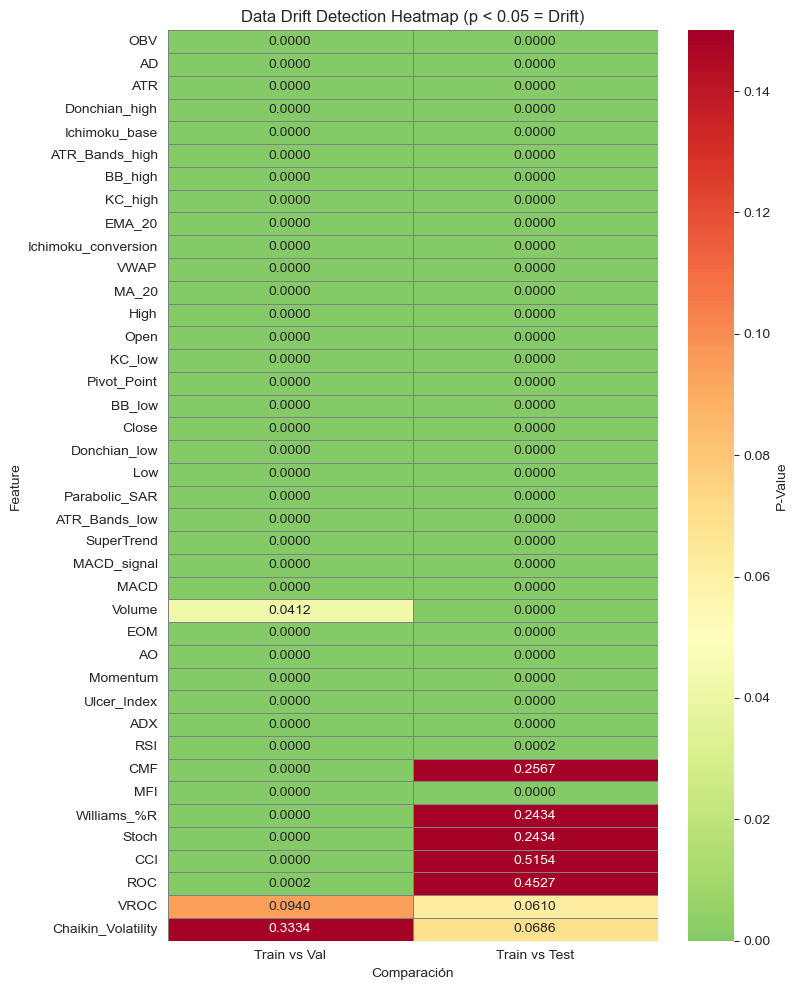

In [4]:
# ===============================
# Visualización de resultados
# ===============================
import seaborn as sns
import matplotlib.pyplot as plt

def plot_drift_heatmap(df_drift):
    """Heatmap de p-values."""
    drift_matrix = df_drift[['Feature', 'P_Value_TrainVal', 'P_Value_TrainTest']].set_index('Feature')
    drift_matrix.columns = ['Train vs Val', 'Train vs Test']
    plt.figure(figsize=(8, max(6, len(drift_matrix) * 0.25)))
    sns.heatmap(
        drift_matrix.astype(float),
        annot=True, fmt=".4f", cmap='RdYlGn_r', center=0.05, vmin=0, vmax=0.15,
        linewidths=0.5, linecolor='gray', cbar_kws={'label': 'P-Value'}
    )
    plt.title("Data Drift Detection Heatmap (p < 0.05 = Drift)")
    plt.xlabel("Comparación")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig(OUTDIR / "drift_heatmap.png", dpi=150)
    plt.show()

def plot_feature_timeline(train, val, test, feature):
    """Distribución + serie temporal de una feature."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    sns.histplot(train[feature], color='blue', kde=True, label='Train', ax=axes[0], alpha=0.5)
    sns.histplot(val[feature], color='orange', kde=True, label='Val', ax=axes[0], alpha=0.5)
    sns.histplot(test[feature], color='green', kde=True, label='Test', ax=axes[0], alpha=0.5)
    axes[0].set_title(f"{feature} - Distribución")
    axes[0].legend()

    if 'date' in train.columns:
        full_df = pd.concat([train, val, test]).reset_index(drop=True)
        axes[1].plot(full_df['date'], full_df[feature], color='gray')
        axes[1].set_title(f"{feature} - Evolución temporal")
    else:
        axes[1].text(0.5, 0.5, 'No hay fechas disponibles', ha='center')
    plt.tight_layout()
    plt.show()

# Ejecutar visualizaciones
plot_drift_heatmap(df_drift)


In [5]:
# ==========================================
# Generar resumen de top 5 features con drift
# ==========================================

def generate_top5_summary(df_drift):
    """Interpreta las 5 features con mayor drift."""
    top5 = df_drift.head(5).copy()
    summary = []
    for _, row in top5.iterrows():
        f = row['Feature']
        if any(x in f for x in ['OBV', 'AD', 'Volume']):
            meaning = "Cambio en volumen o liquidez del mercado."
        elif any(x in f for x in ['ATR', 'Donchian', 'Volatility']):
            meaning = "Cambio de régimen de volatilidad."
        elif any(x in f for x in ['Ichimoku', 'EMA']):
            meaning = "Cambio en tendencia o estructura de precios."
        else:
            meaning = "Cambio distributivo significativo."
        summary.append({
            "Feature": f,
            "KS": round(row['Max_KS_Stat'], 4),
            "P_Value": round(row['Min_P_Value'], 6),
            "Interpretación": meaning
        })
    return pd.DataFrame(summary)

df_top5 = generate_top5_summary(df_drift)
df_top5


,Feature,KS,P_Value,Interpretación
0,OBV,1.0000,0.0,Cambio en volumen o liquidez del mercado.
1,AD,0.9969,0.0,Cambio en volumen o liquidez del mercado.
2,ATR,0.9710,0.0,Cambio de régimen de volatilidad.
3,Donchian_high,0.9416,0.0,Cambio de régimen de volatilidad.
4,Ichimoku_base,0.9412,0.0,Cambio en tendencia o estructura de precios.


--- OBV ---


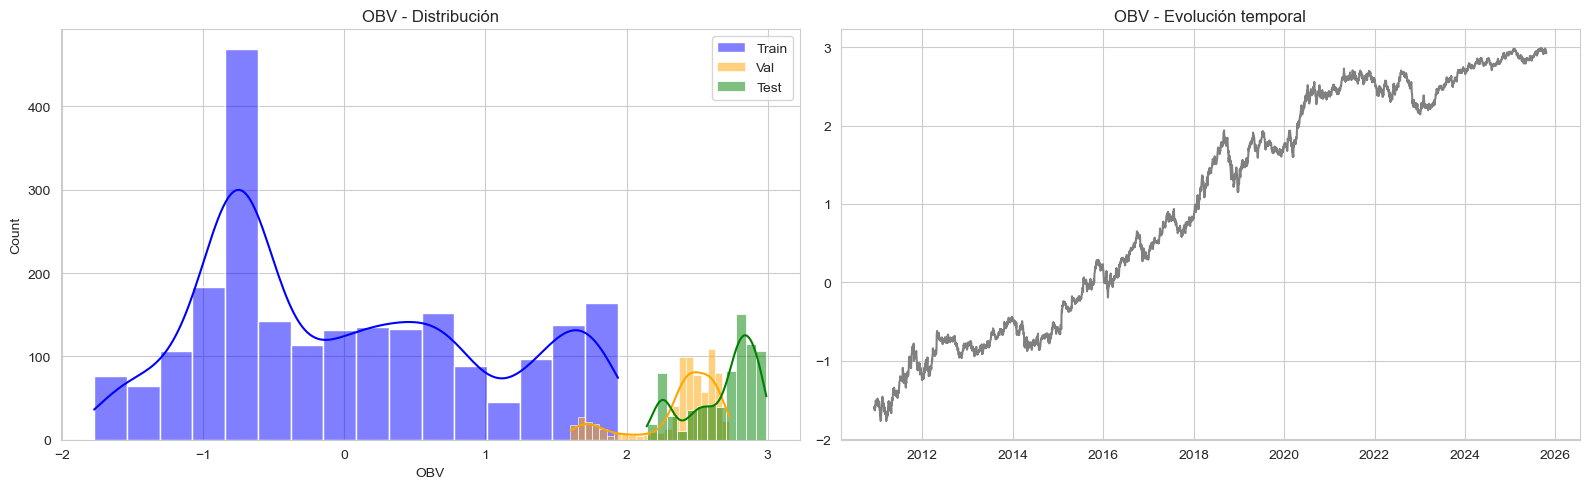

--- AD ---


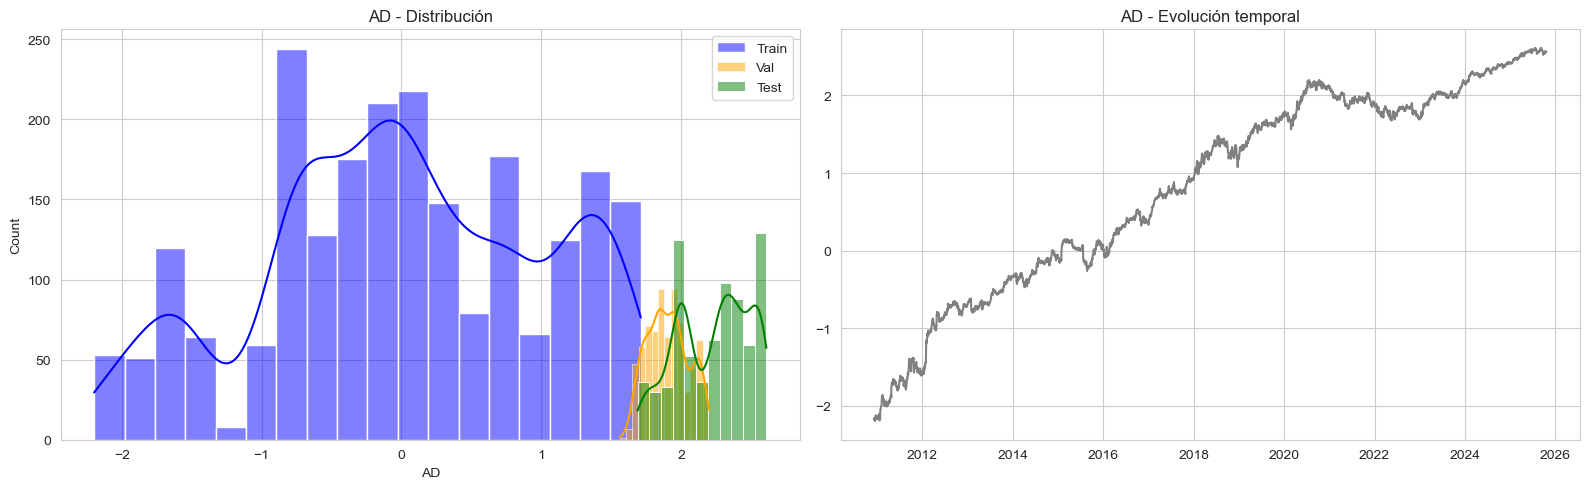

--- ATR ---


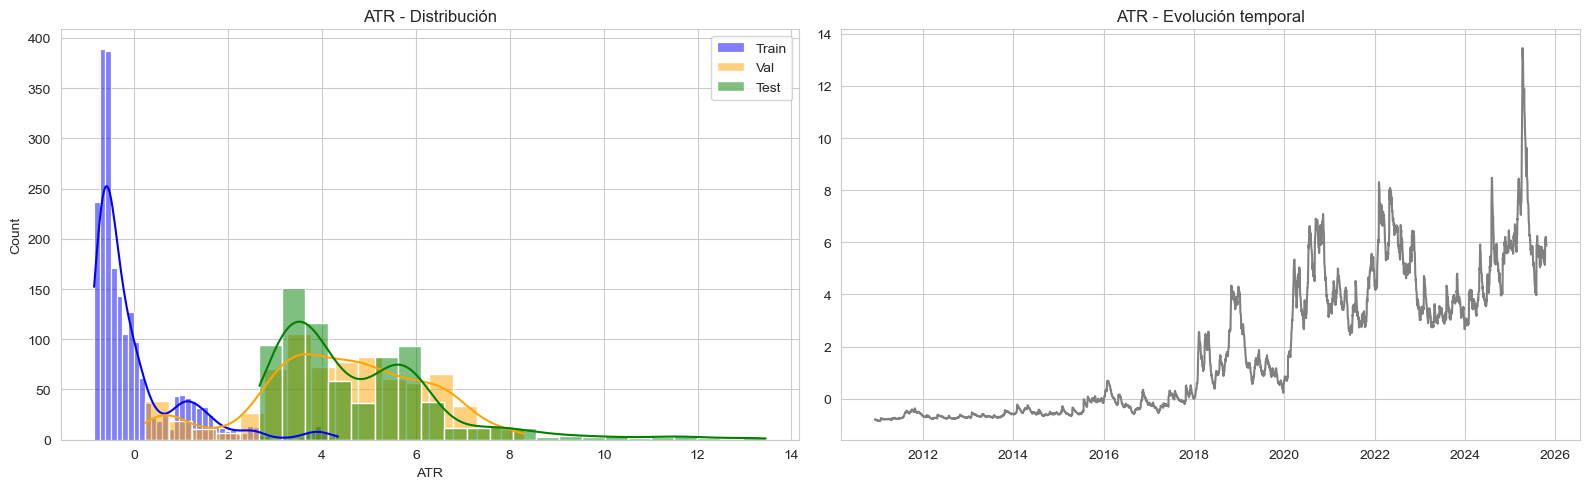

--- Donchian_high ---


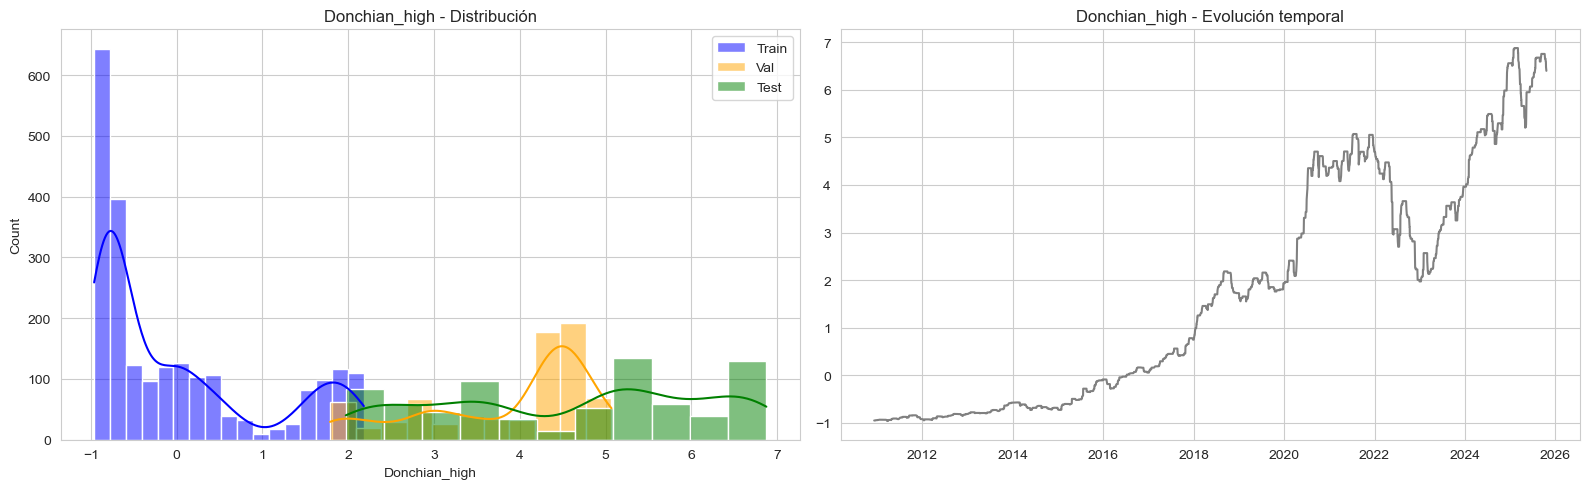

--- Ichimoku_base ---


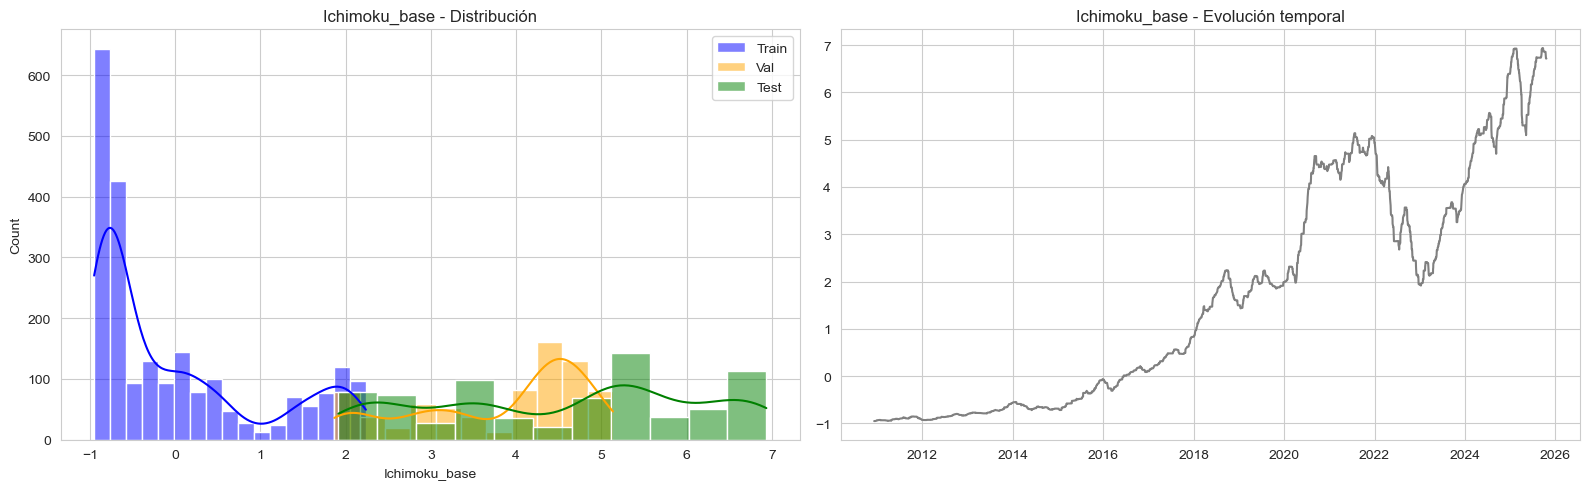

In [6]:
# Mostrar evolución de las 5 variables con mayor drift
for f in df_top5['Feature']:
    print(f"--- {f} ---")
    plot_feature_timeline(train_scaled, val_scaled, test_scaled, f)



TOP 3 FEATURES CON MAYOR DRIFT POR CATEGORÍA

📊 Indicadores Estables / Otros
--------------------------------------------------------------------------------
  1. High                           | KS: 0.9162 | 🟠 ALTO
  2. Open                           | KS: 0.9135 | 🟠 ALTO
  3. Pivot_Point                    | KS: 0.9090 | 🟠 ALTO

📊 Indicadores de Volatilidad
--------------------------------------------------------------------------------
  1. ATR                            | KS: 0.9710 | 🔴 MUY ALTO
  2. Donchian_high                  | KS: 0.9416 | 🔴 MUY ALTO
  3. ATR_Bands_high                 | KS: 0.9389 | 🔴 MUY ALTO

📊 Indicadores de Volumen
--------------------------------------------------------------------------------
  1. OBV                            | KS: 1.0000 | 🔴 CRÍTICO
  2. AD                             | KS: 0.9969 | 🔴 CRÍTICO
  3. Volume                         | KS: 0.4530 | 🟢 BAJO

📊 Medias Móviles
-----------------------------------------------------------------

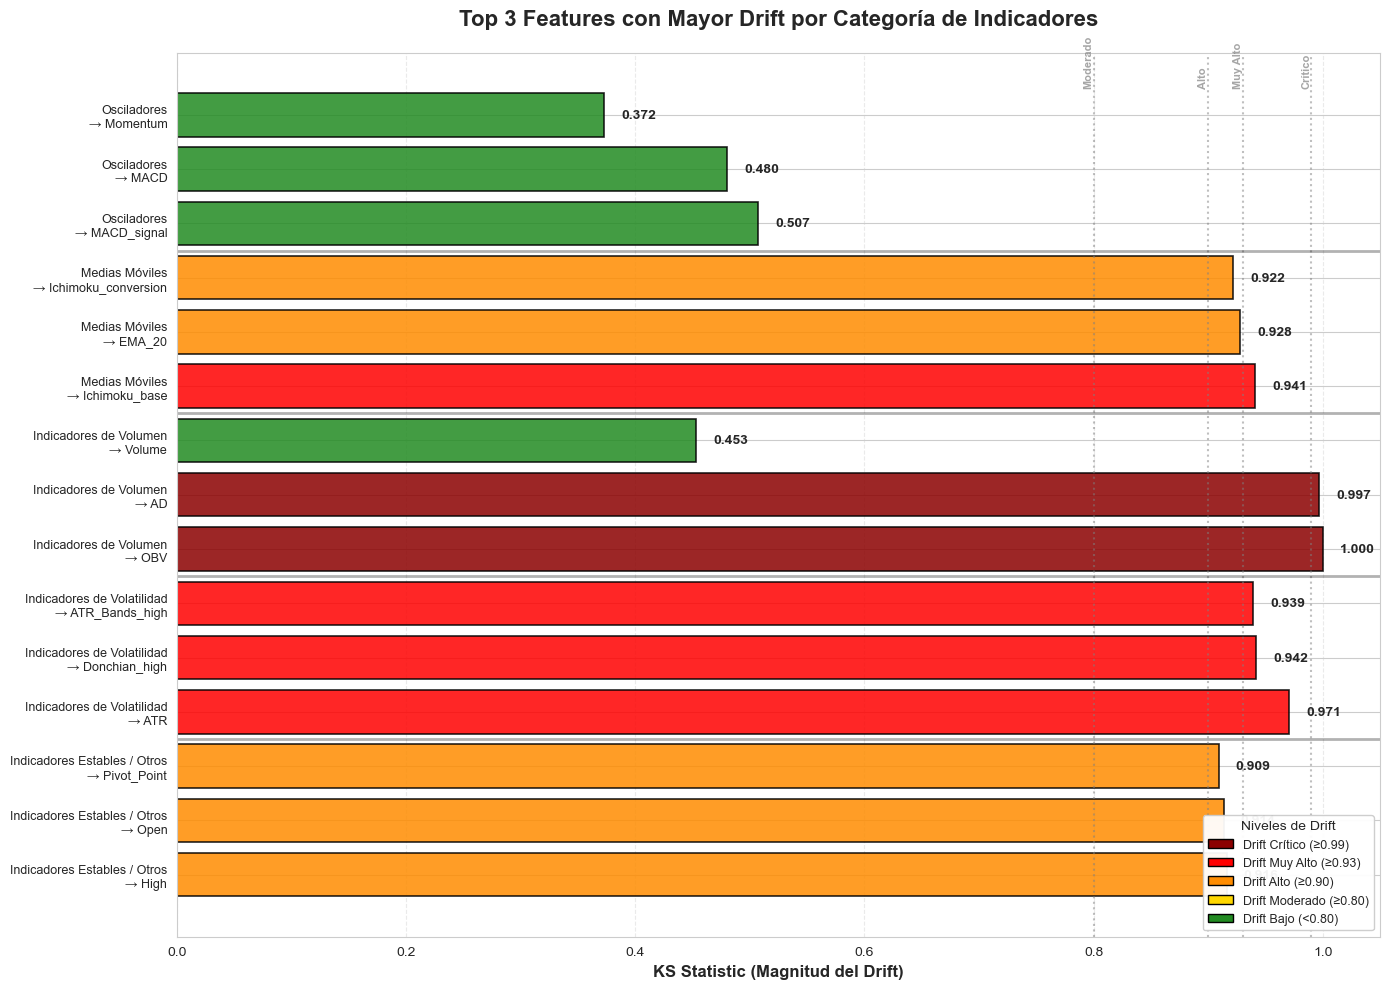

In [11]:
# Categorías de features
categories = {
    "Indicadores de Volumen": [
        "OBV", "AD", "Volume", "EOM", "AO", "CMF", "MFI", "VROC"
    ],
    "Indicadores de Volatilidad": [
        "ATR", "ATR_Bands_high", "ATR_Bands_low", "BB_high", "BB_low",
        "KC_high", "KC_low", "Donchian_high", "Donchian_low",
        "Chaikin_Volatility", "Ulcer_Index", "SuperTrend", "Parabolic_SAR"
    ],
    "Medias Móviles": [
        "EMA_20", "MA_20", "VWAP", "Ichimoku_base", "Ichimoku_conversion"
    ],
    "Osciladores": [
        "RSI", "MACD", "MACD_signal", "Stoch", "Momentum", "ROC"
    ],
    "Indicadores Estables / Otros": [
        "CCI", "Williams_%R", "Pivot_Point", "High", "Low", "Open", "Close"
    ]
}

# Obtener top 3 features con mayor drift por categoría
top_features_data = []

for cat, keywords in categories.items():
    # Crear máscara para features que contienen alguna palabra clave
    mask = df_drift["Feature"].apply(
        lambda f: any(keyword in f for keyword in keywords)
    )
    subset = df_drift[mask].copy()
    
    if len(subset) > 0:
        # Ordenar por KS y tomar top 3
        top_3 = subset.nlargest(3, "Max_KS_Stat")
        
        for _, row in top_3.iterrows():
            top_features_data.append({
                "Categoría": cat,
                "Feature": row["Feature"],
                "KS_Stat": row["Max_KS_Stat"]
            })

# Crear DataFrame con top 3 features por categoría
df_top_features = pd.DataFrame(top_features_data)

# Ordenar por categoría y KS descendente
df_top_features = df_top_features.sort_values(
    ["Categoría", "KS_Stat"], 
    ascending=[True, False]
).reset_index(drop=True)

# Definir función de color mejorada
def ks_color(value):
    """Asigna color basado en el nivel de drift"""
    if value >= 0.99:
        return "#8B0000"    # Dark Red - Drift crítico
    elif value >= 0.93:
        return "#FF0000"    # Bright Red - Drift muy alto
    elif value >= 0.90:
        return "#FF8C00"    # Orange - Drift alto
    elif value >= 0.80:
        return "#FFD700"    # Yellow - Drift moderado
    else:
        return "#228B22"    # Green - Drift bajo

# Aplicar colores
df_top_features["Color"] = df_top_features["KS_Stat"].apply(ks_color)

# Crear etiquetas combinadas (categoría + feature)
df_top_features["Label"] = df_top_features.apply(
    lambda row: f"{row['Categoría']}\n  → {row['Feature']}", 
    axis=1
)

# Crear figura con mejor diseño
fig, ax = plt.subplots(figsize=(14, 10))

# Crear barras horizontales con colores personalizados
y_positions = range(len(df_top_features))
bars = ax.barh(
    y=y_positions,
    width=df_top_features["KS_Stat"],
    color=df_top_features["Color"],
    edgecolor='black',
    linewidth=1.2,
    alpha=0.85
)

# Configurar etiquetas del eje Y
ax.set_yticks(y_positions)
ax.set_yticklabels(df_top_features["Label"], fontsize=9)

# Títulos y etiquetas
ax.set_title(
    "Top 3 Features con Mayor Drift por Categoría de Indicadores",
    fontsize=16,
    fontweight="bold",
    pad=20
)
ax.set_xlabel("KS Statistic (Magnitud del Drift)", fontsize=12, fontweight="bold")
ax.set_ylabel("")

# Añadir valores al final de cada barra
for i, row in df_top_features.iterrows():
    ax.text(
        row["KS_Stat"] + 0.015,
        i,
        f"{row['KS_Stat']:.3f}",
        va="center",
        ha="left",
        fontsize=10,
        fontweight="bold"
    )

# Configurar límites y grid
ax.set_xlim(0, 1.05)
ax.grid(axis="x", linestyle="--", alpha=0.4, zorder=0)

# Añadir líneas de referencia para niveles de drift
drift_levels = [
    (0.99, "Crítico"),
    (0.93, "Muy Alto"),
    (0.90, "Alto"),
    (0.80, "Moderado")
]

for level, label in drift_levels:
    ax.axvline(
        x=level,
        color='gray',
        linestyle=":",
        linewidth=1.5,
        alpha=0.5,
        zorder=1
    )
    ax.text(
        level,
        len(df_top_features) - 0.5,
        label,
        rotation=90,
        va="bottom",
        ha="right",
        fontsize=8,
        color='gray',
        fontweight="bold",
        alpha=0.7
    )

# Añadir separadores visuales entre categorías
current_cat = None
for i, row in df_top_features.iterrows():
    if row["Categoría"] != current_cat:
        if current_cat is not None:
            ax.axhline(y=i-0.5, color='black', linewidth=2, alpha=0.3)
        current_cat = row["Categoría"]

# Añadir leyenda de colores
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="#8B0000", edgecolor='black', label='Drift Crítico (≥0.99)'),
    Patch(facecolor="#FF0000", edgecolor='black', label='Drift Muy Alto (≥0.93)'),
    Patch(facecolor="#FF8C00", edgecolor='black', label='Drift Alto (≥0.90)'),
    Patch(facecolor="#FFD700", edgecolor='black', label='Drift Moderado (≥0.80)'),
    Patch(facecolor="#228B22", edgecolor='black', label='Drift Bajo (<0.80)')
]
ax.legend(
    handles=legend_elements,
    loc='lower right',
    framealpha=0.95,
    fontsize=9,
    title="Niveles de Drift",
    title_fontsize=10
)

plt.tight_layout()
fig.show()

# Imprimir resumen en consola
print("\n" + "="*80)
print("TOP 3 FEATURES CON MAYOR DRIFT POR CATEGORÍA")
print("="*80)

for cat in df_top_features["Categoría"].unique():
    print(f"\n📊 {cat}")
    print("-" * 80)
    cat_data = df_top_features[df_top_features["Categoría"] == cat]
    for idx, (_, row) in enumerate(cat_data.iterrows(), 1):
        drift_level = "🔴 CRÍTICO" if row["KS_Stat"] >= 0.99 else \
                      "🔴 MUY ALTO" if row["KS_Stat"] >= 0.93 else \
                      "🟠 ALTO" if row["KS_Stat"] >= 0.90 else \
                      "🟡 MODERADO" if row["KS_Stat"] >= 0.80 else \
                      "🟢 BAJO"
        print(f"  {idx}. {row['Feature']:30s} | KS: {row['KS_Stat']:.4f} | {drift_level}")

print("\n" + "="*80)